In [1]:
from utils.preprocess import Preprocessing as prep
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zofia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
data = pd.read_csv('datasets/cefr_leveled_texts.csv')
data2 = pd.read_csv('datasets/cefr_leveled_texts_2.csv')
data.head()

,text,label
0,Hi!\nI've been meaning to write for ages and f...,B2
1,﻿It was not so much how hard people found the ...,B2
2,Keith recently came back from a trip to Chicag...,B2
3,"The Griffith Observatory is a planetarium, and...",B2
4,-LRB- The Hollywood Reporter -RRB- It's offici...,B2


<Axes: ylabel='text'>

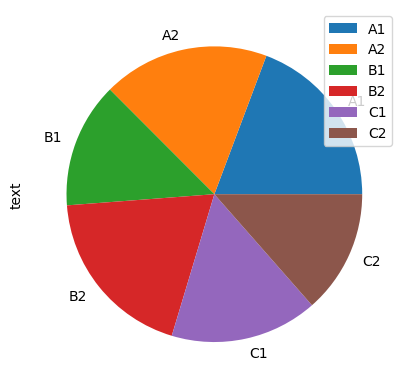

In [21]:
labels_count = data.groupby(['label']).count()
labels_count.plot.pie(y="text")

<Axes: ylabel='text'>

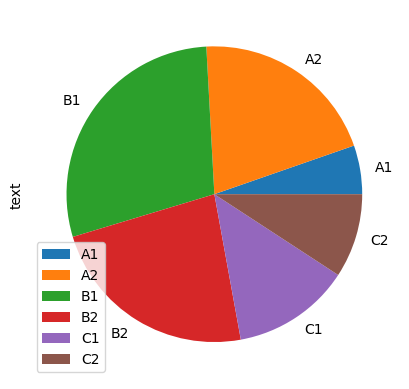

In [11]:
labels_count = data2.groupby(['label']).count()
labels_count.plot.pie(y="text")

<Axes: ylabel='text'>

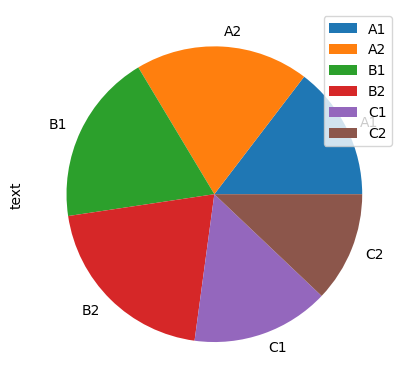

In [22]:
data = pd.concat([data,data2])
labels_count = data.groupby(['label']).count()
labels_count.plot.pie(y="text")

In [14]:
len(data)

2244

In [15]:
data.groupby(['label']).count()

,text
label,
A1,328
A2,426
B1,421
B2,460
C1,338
C2,271


# Machine Learning models

In [13]:
len(data)

2244

<Axes: ylabel='text'>

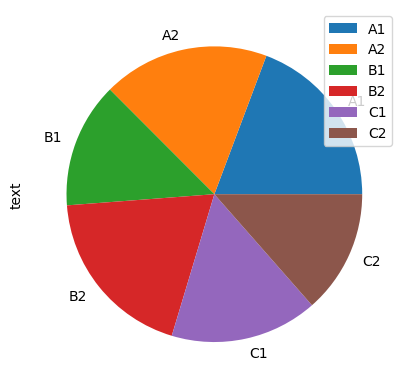

In [4]:
labels_count = data.groupby(['label']).count()
labels_count.plot.pie(y="text")

In [5]:
new_data['text'] = prep.clean(data['text'])
new_data['label'] = data['label'].apply(lambda x: prep.encode_label(x))

In [6]:
new_data.head()

,text,label
0,hi v mean write ag final todai m actual someth...,4
1,﻿it wa hard peopl challeng far thei avoid left...,4
2,keith recent came trip chicago illinois thi mi...,4
3,griffith observatori planetarium exhibit hall ...,4
4,lrb hollywood report rrb official amc walk dea...,4


In [7]:
X = prep.apply_tfidf(new_data['text'])
y = new_data['label']

In [15]:
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.06600131, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [16]:
y

0       4
1       4
2       4
3       4
4       4
       ..
1489    6
1490    6
1491    6
1492    6
1493    6
Name: label, Length: 1494, dtype: int64

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

## MLP model

In [41]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,100,100,50,80),alpha=0.001,max_iter=1000)
mlp_model.fit(X_train,y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 100, 100, 50, 80),
              max_iter=1000)

In [42]:
mlp_model.score(X_test,y_test)

0.56951871657754

In [44]:
label_names = ['A1','A2','B1','B2','C1','C2']
print(classification_report(y_test,mlp_model.predict(X_test),target_names=label_names))

              precision    recall  f1-score   support

          A1       0.77      0.83      0.80        76
          A2       0.70      0.48      0.57        73
          B1       0.41      0.48      0.44        50
          B2       0.46      0.47      0.47        72
          C1       0.44      0.63      0.52        59
          C2       0.77      0.45      0.57        44

    accuracy                           0.57       374
   macro avg       0.59      0.56      0.56       374
weighted avg       0.60      0.57      0.57       374



In [33]:
param_grid = {
    'hidden_layer_sizes': [(100,100,100,50,80),(100,100,100,50,80,50)],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

In [26]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(mlp_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0.001,
                                     hidden_layer_sizes=(100, 100, 100, 50, 80),
                                     max_iter=1000),
             param_grid={'hidden_layer_sizes': [(100, 100, 100, 50, 80),
                                                (100, 100, 100, 50, 80, 50)],
                         'learning_rate_init': [0.001, 0.01, 0.1]})

In [34]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 100, 100, 50, 80),
              max_iter=1000)

In [36]:
best_model.score(X_test,y_test)

0.5267379679144385

## MultinomialNB

In [48]:
from sklearn.naive_bayes import MultinomialNB
mnb_model = MultinomialNB()
mnb_model.fit(X_train,y_train)

MultinomialNB()

In [49]:
mnb_model.score(X_test,y_test)

0.5614973262032086

In [50]:
label_names = ['A1','A2','B1','B2','C1','C2']
print(classification_report(y_test,mnb_model.predict(X_test),target_names=label_names))

              precision    recall  f1-score   support

          A1       0.81      0.68      0.74        76
          A2       0.60      0.79      0.69        73
          B1       1.00      0.06      0.11        50
          B2       0.42      0.67      0.52        72
          C1       0.41      0.54      0.47        59
          C2       0.89      0.39      0.54        44

    accuracy                           0.56       374
   macro avg       0.69      0.52      0.51       374
weighted avg       0.67      0.56      0.54       374



## Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=10)
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [52]:
dt_model.score(X_test,y_test)

0.3770053475935829

In [53]:
label_names = ['A1','A2','B1','B2','C1','C2']
print(classification_report(y_test,dt_model.predict(X_test),target_names=label_names))

              precision    recall  f1-score   support

          A1       0.49      0.82      0.61        76
          A2       0.34      0.26      0.29        73
          B1       0.27      0.16      0.20        50
          B2       0.32      0.25      0.28        72
          C1       0.29      0.29      0.29        59
          C2       0.36      0.39      0.37        44

    accuracy                           0.38       374
   macro avg       0.34      0.36      0.34       374
weighted avg       0.35      0.38      0.35       374



## Logistic Regression

### Standard scaler

In [54]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
import numpy as np

pipe_standard = make_pipeline(
    preprocessing.StandardScaler(), 
    LogisticRegressionCV(
        solver='lbfgs',
        max_iter=500))
pipe_standard.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv', LogisticRegressionCV(max_iter=500))])

In [55]:
pipe_standard.score(X_test,y_test)

0.5882352941176471

In [56]:
label_names = ['A1','A2','B1','B2','C1','C2']
print(classification_report(y_test,pipe_standard.predict(X_test),target_names=label_names))

              precision    recall  f1-score   support

          A1       0.76      0.91      0.83        76
          A2       0.76      0.73      0.74        73
          B1       0.54      0.28      0.37        50
          B2       0.43      0.49      0.45        72
          C1       0.38      0.42      0.40        59
          C2       0.60      0.55      0.57        44

    accuracy                           0.59       374
   macro avg       0.58      0.56      0.56       374
weighted avg       0.59      0.59      0.58       374



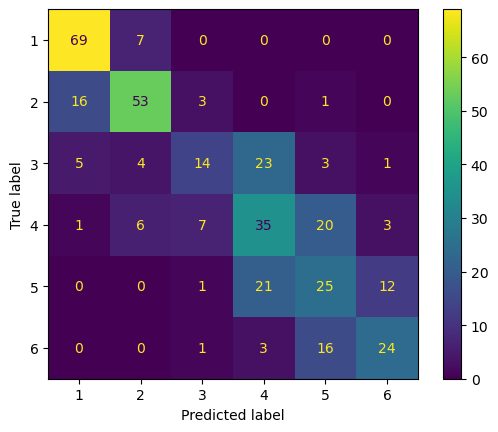

In [58]:
import matplotlib.pyplot as plt  
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipe_standard, X_test, y_test) 
plt.show()

### Minmax scaler

In [59]:
pipe_minmax = make_pipeline(preprocessing.MinMaxScaler(), LogisticRegressionCV(max_iter=500))
pipe_minmax.fit(X_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv', LogisticRegressionCV(max_iter=500))])

In [62]:
pipe_minmax.score(X_test,y_test)

0.5935828877005348

In [65]:
label_names = ['A1','A2','B1','B2','C1','C2']
print(classification_report(y_test,pipe_minmax.predict(X_test),target_names=label_names))

              precision    recall  f1-score   support

          A1       0.75      0.86      0.80        76
          A2       0.72      0.73      0.72        73
          B1       0.56      0.30      0.39        50
          B2       0.43      0.47      0.45        72
          C1       0.42      0.46      0.44        59
          C2       0.67      0.64      0.65        44

    accuracy                           0.59       374
   macro avg       0.59      0.57      0.57       374
weighted avg       0.59      0.59      0.59       374



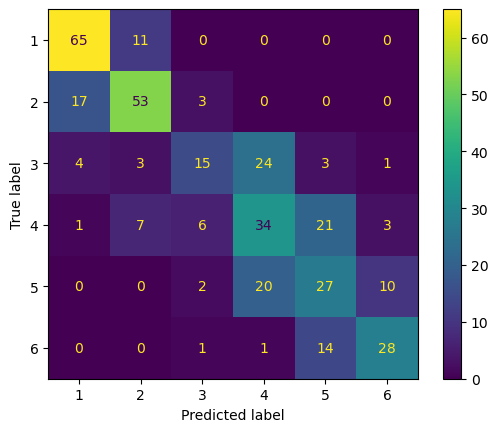

In [63]:
ConfusionMatrixDisplay.from_estimator(pipe_minmax, X_test, y_test) 
plt.show()

In [64]:
pipe_maxabs = make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegressionCV(max_iter=500))
pipe_maxabs.fit(X_train,y_train)

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('logisticregressioncv', LogisticRegressionCV(max_iter=500))])

In [66]:
pipe_maxabs.score(X_test,y_test)

0.5935828877005348

In [68]:
label_names = ['A1','A2','B1','B2','C1','C2']
print(classification_report(y_test,pipe_maxabs.predict(X_test),target_names=label_names))

              precision    recall  f1-score   support

          A1       0.75      0.86      0.80        76
          A2       0.72      0.73      0.72        73
          B1       0.56      0.30      0.39        50
          B2       0.43      0.47      0.45        72
          C1       0.42      0.46      0.44        59
          C2       0.67      0.64      0.65        44

    accuracy                           0.59       374
   macro avg       0.59      0.57      0.57       374
weighted avg       0.59      0.59      0.59       374



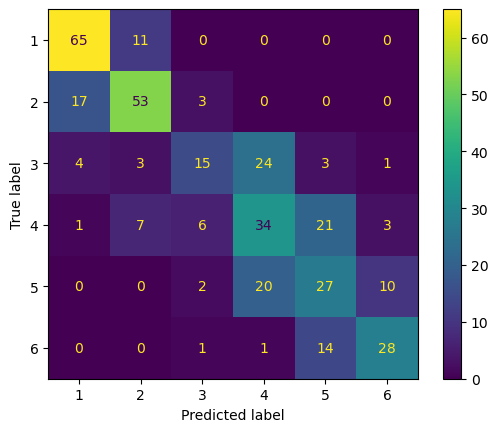

In [69]:
ConfusionMatrixDisplay.from_estimator(pipe_maxabs, X_test, y_test) 
plt.show()

# GloVe

In [72]:
from gensim.models import KeyedVectors

glove_model = KeyedVectors.load_word2vec_format('glove_6B_300d.txt', binary=False)


In [73]:
data['text_lower'] = data['text'].apply(lambda x: x.replace("\n"," ").lower())
data.head()

,text,label,text_lower
0,Hi!\nI've been meaning to write for ages and f...,B2,hi! i've been meaning to write for ages and fi...
1,﻿It was not so much how hard people found the ...,B2,﻿it was not so much how hard people found the ...
2,Keith recently came back from a trip to Chicag...,B2,keith recently came back from a trip to chicag...
3,"The Griffith Observatory is a planetarium, and...",B2,"the griffith observatory is a planetarium, and..."
4,-LRB- The Hollywood Reporter -RRB- It's offici...,B2,-lrb- the hollywood reporter -rrb- it's offici...


In [74]:
glove_data = pd.DataFrame()
glove_data['text'] = data['text_lower']
glove_data['label'] = data['label'].apply(lambda x: prep.encode_label(x))
glove_data.head()

,text,label
0,hi! i've been meaning to write for ages and fi...,4
1,﻿it was not so much how hard people found the ...,4
2,keith recently came back from a trip to chicag...,4
3,"the griffith observatory is a planetarium, and...",4
4,-lrb- the hollywood reporter -rrb- it's offici...,4


In [75]:
#map each word in the text to the corresponding word vector
def map_word_to_vector(text):
    word_vectors = np.array([])
    for word in text.split(" "):
        try:
            word_vectors = np.append(word_vectors,glove_model[word])
        except:
            pass
    return word_vectors

In [76]:
def map_dataset_to_vectors(texts):
    vectorized_texts = texts.apply(lambda x: map_word_to_vector(x)).to_numpy()
    max_len = max([len(x) for x in vectorized_texts])
    print(max_len)
    padded_texts = np.array([x if len(x) == max_len else np.append(x,np.zeros(max_len-len(x))) for x in vectorized_texts])
    return padded_texts

In [77]:
articles_glove = map_dataset_to_vectors(glove_data['text'])

584400


In [78]:
labels = glove_data['label'].to_numpy()

In [79]:
print(labels.shape)

(1494,)


In [80]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(articles_glove,labels)

In [81]:
print(type(X_train[0]))
print(len(X_train[0]))
print(len(X_train[2]))
print(len(X_train[3]))

<class 'numpy.ndarray'>
584400
584400
584400


## Training the GloVe encoded dataset with Logistic Regression

In [107]:
from sklearn.decomposition import PCA
N_COMPONENTS = 1000
pca = PCA(n_components=N_COMPONENTS)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [110]:
len(X_train[0]), len(X_train_pca[0])

(584400, 1000)

In [111]:
glove_logreg = LogisticRegressionCV(max_iter=500)
glove_logreg.fit(X_train_pca,y_train)

/Users/zofia/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zofia/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisticRegressionCV(max_iter=500)

In [112]:
X_test_pca = pca.transform(X_test)

In [116]:
glove_logreg.score(X_test_pca,y_test)

0.5454545454545454

In [114]:
print(classification_report(y_test,glove_logreg.predict(X_test_pca),target_names=label_names))

              precision    recall  f1-score   support

          A1       0.65      0.92      0.76        72
          A2       0.62      0.58      0.60        71
          B1       0.45      0.29      0.35        48
          B2       0.44      0.40      0.42        72
          C1       0.39      0.50      0.44        58
          C2       0.69      0.47      0.56        53

    accuracy                           0.55       374
   macro avg       0.54      0.53      0.52       374
weighted avg       0.55      0.55      0.53       374



# Feature engineering

### L2 dataset

In [23]:
import textstat

In [18]:
#data = pd.read_csv('datasets/texts_l2.csv')
l2_dataset = pd.read_csv('datasets/texts_l2.csv',sep='	')
len(l2_dataset)
# data = l2_dataset[['Text','Proficiency']]
# data.columns = ['text','label']

1810

In [24]:
data.groupby('label').count()

,text
label,
A1,328
A2,426
B1,421
B2,460
C1,338
C2,271


In [25]:
data['label'] = data['label'].apply(lambda x: x[:2])
data.groupby('label').count()

,text
label,
A1,328
A2,426
B1,421
B2,460
C1,338
C2,271


### CEFR texts dataset

In [26]:
data['encoded_label'] = data['label'].apply(lambda x: prep.encode_label(x))

<Axes: xlabel='encoded_label'>

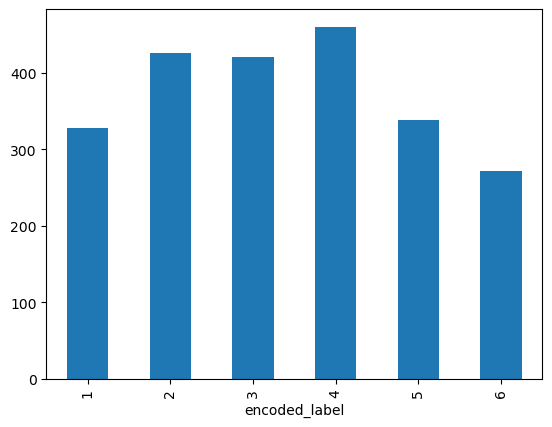

In [27]:
data['encoded_label'].groupby(data['encoded_label']).count().plot(kind='bar')

In [28]:
def descrease_classes(class_label):
    if class_label <=2:
        return 1
    elif class_label <=4:
        return 2
    else:
        return 3
data['encoded_label_simple'] = data['encoded_label'].apply(lambda x: descrease_classes(x))

<Axes: xlabel='encoded_label_simple'>

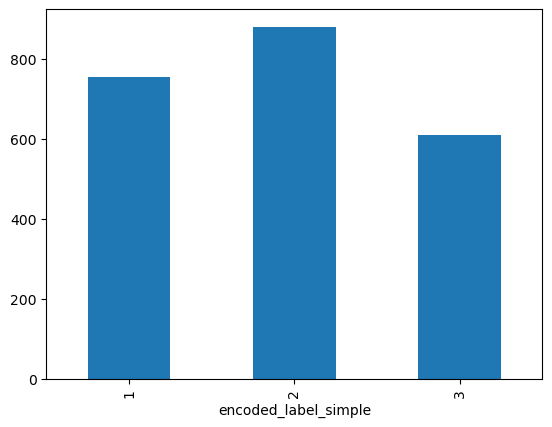

In [29]:
data['encoded_label_simple'].groupby(data['encoded_label_simple']).count().plot(kind='bar')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['encoded_label'], test_size=0.2, random_state=42)

In [31]:
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

def get_pos_frequencies(sentence):
    pos_tags = pos_tag(word_tokenize(sentence))
    pos_frequencies = {}
    for tag in pos_tags:
         if tag[1] in pos_frequencies:
             pos_frequencies[tag[1]] += 1
         else:
             pos_frequencies[tag[1]] = 1
    return pos_frequencies

def get_mean_pos(text):
    sentences = [get_pos_frequencies(sent) for sent in text]
    nr_of_sentences = len(sentences)
    mean_pos = {}
    for sent in sentences:
        for pos in sent.keys():
            if pos in mean_pos.keys():
                mean_pos[pos]+=1
            else:
                mean_pos[pos] = 1
    mean_pos = dict(map(lambda x : (x[0], x[1]/nr_of_sentences), mean_pos.items()))

    return mean_pos

In [32]:
get_mean_pos("This is a test sentence. This is another test sentence.")

{'NN': 0.7272727272727273,
 'DT': 0.03636363636363636,
 'NNS': 0.03636363636363636,
 '.': 0.03636363636363636}

In [33]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner'])
def tree_depth(root):
    if not list(root.children):
        return 1
    else:
        return 1 + max(tree_depth(x) for x in root.children)
    
def get_avg_parse_tree_depth(text):
    doc = nlp(text)
    roots = [sent.root for sent in doc.sents]
    return (np.mean([tree_depth(root) for root in roots]),[tree_depth(root) for root in roots])

In [34]:
get_avg_parse_tree_depth("This is a test. I hope it works. I want a very complicated sentence about the economy, that includes many subsentences such as this one \'I am the best f1 driver\'.")

(4.0, [3, 3, 6])

In [36]:
def extract_features(text,with_pos=False):
    features= {
        'length': len(text),
        'num_words': len(text.split(" ")),
        'num_sentences': len(nltk.sent_tokenize(text)),
        'avg_word_length': np.mean([len(word) for word in text.split(" ")]),
        'avg_sentence_length': np.mean([len(sentence.split(" ")) for sentence in text.split(".")]),
        'smog': textstat.smog_index(text),
        'flesch': textstat.flesch_reading_ease(text),
        'dalle-chall': textstat.dale_chall_readability_score(text),
        'difficult_words': textstat.difficult_words(text),
        'linsear': textstat.linsear_write_formula(text),
        'text_standard': textstat.text_standard(text,float_output=True),
        'readability':textstat.automated_readability_index(text),
        'avg_parse_tree': get_avg_parse_tree_depth(text)[0],
        'max_parse_tree': max(get_avg_parse_tree_depth(text)[1]),
        'min_parse_tree': min(get_avg_parse_tree_depth(text)[1]),
    }
    if with_pos:
        features.update(get_mean_pos(text))
    return features

In [37]:
X_train.apply(lambda x: get_pos_frequencies(x))[0]

{'NN': 52,
 '.': 24,
 'PRP': 48,
 'VBP': 11,
 'VBN': 11,
 'VBG': 16,
 'TO': 20,
 'VB': 29,
 'IN': 57,
 'NNS': 11,
 'CC': 18,
 'RB': 42,
 ',': 23,
 'VBZ': 12,
 'JJ': 31,
 'RP': 5,
 'VBD': 22,
 'DT': 30,
 'PRP$': 5,
 'CD': 4,
 'JJR': 2,
 'NNP': 25,
 'MD': 10,
 'WRB': 6,
 'JJS': 3,
 'EX': 1,
 '(': 1,
 ')': 1,
 ':': 1,
 'WDT': 3,
 'POS': 1}

In [25]:
X_train.apply(lambda x: extract_features(x))[0]

{'length': 2335,
 'num_words': 453,
 'num_sentences': 26,
 'avg_word_length': 4.156732891832229,
 'avg_sentence_length': 23.6,
 'smog': 8.5,
 'flesch': 86.03,
 'dalle-chall': 6.55,
 'difficult_words': 34,
 'linsear': 8.666666666666666,
 'text_standard': 6.0,
 'readability': 7.5,
 'avg_parse_tree': 5.5,
 'max_parse_tree': 10,
 'min_parse_tree': 2}

In [38]:
def train_classifier(X_train, y_train, classifier, with_pos=True):
    X_train_featurized = X_train.apply(lambda x: extract_features(x, with_pos=with_pos))
    classifier.fit(X_train_featurized, y_train)
    return classifier

### Logistic Regression

In [39]:
pipe = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', LogisticRegressionCV(max_iter=1000, class_weight="balanced",multi_class='multinomial'))
])

In [40]:
pipe = train_classifier(X_train, y_train, pipe,with_pos=False)

/opt/homebrew/anaconda3/envs/bsp6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/envs/bsp6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

In [41]:
X_test_featurized = X_test.apply(lambda x: extract_features(x)).tolist()
pipe.score(X_test_featurized, y_test)

0.5723830734966593

In [42]:
from sklearn.metrics import classification_report
label_names = ['A1','A2','B1','B2','C1','C2']
y_pred = pipe.predict(X_test_featurized)
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

          A1       0.65      0.79      0.71        63
          A2       0.59      0.47      0.52       104
          B1       0.45      0.46      0.45        79
          B2       0.56      0.61      0.58        94
          C1       0.53      0.51      0.52        61
          C2       0.69      0.71      0.70        48

    accuracy                           0.57       449
   macro avg       0.58      0.59      0.58       449
weighted avg       0.57      0.57      0.57       449



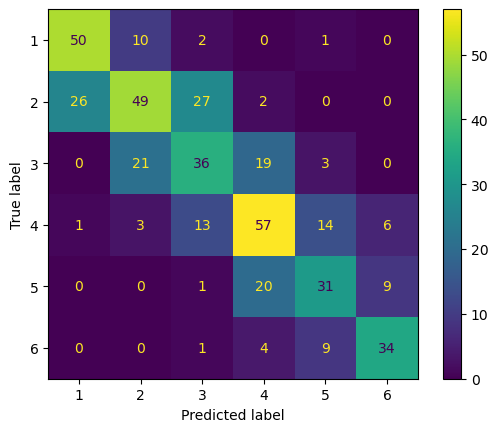

In [43]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test_featurized, y_test)

example

In [44]:
#example_text = "Hello! I would like to tell you about my daily routine. I'm not a morning person, so I usually wake up around 8 o'clock in the morning. After getting up, I wash my face and brush my teeth. Then, I have a quick breakfast, usually some cereal or toast with jam. Next, I get ready for the day. I put on my clothes and make sure I have everything I need in my bag. Then, I leave my house and walk to the bus stop. I take the bus to work because it's more convenient and saves time. I work in an office from 9 to 5. My job involves answering emails, making phone calls, and helping my colleagues with their tasks. Sometimes it can be busy, but I try to stay organized and focused. During my lunch break, I usually bring a packed lunch from home. It's usually a sandwich or some leftovers from the previous day. I eat in the office cafeteria and chat with my coworkers. It's nice to take a break and relax for a while. After work, I take the bus back home. When I arrive, I like to unwind by watching TV or reading a book. It helps me to relax and forget about work for a while. Sometimes, I go for a walk in the park near my house if the weather is nice. In the evening, I prepare dinner for myself. I enjoy cooking simple meals like pasta or stir-fry. After dinner, I clean up the dishes and do some light household chores. Then, I take a shower and get ready for bed. Before going to sleep, I like to read a few pages of a book or listen to some calming music. It helps me to relax and fall asleep easily. I try to get around 7 to 8 hours of sleep every night to feel refreshed in the morning. That's a typical day in my life. It may not be very exciting, but it works for me. I believe having a routine helps me stay organized and make the most of my day." 
example_text = "One of the best parts of cooking is being able to share the meals I prepare with others. Whether it's a cozy dinner with my family or a gathering with friends, I love seeing the smiles on their faces as they enjoy the food. It brings people together and creates memorable moments filled with laughter and good conversation.Cooking also allows me to take care of my health. By preparing meals at home, I can choose fresh ingredients and control the amount of oil, salt, and sugar in my dishes. It helps me maintain a balanced diet and make healthier choices for myself and my loved ones.Although cooking can sometimes be challenging, especially when trying a complex recipe, I believe that anyone can enjoy this hobby. It's not about being perfect or having fancy equipment; it's about having fun and expressing oneself through food.In conclusion, cooking is my favorite hobby because it allows me to be creative, try new flavors, and share delicious meals with others. Whether it's a simple dish or a more elaborate recipe, cooking brings joy and fulfillment to my life."
pipe.predict([extract_features(example_text)])

array([4])

### SVM

In [45]:
pipe_svm = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', SVC(kernel='linear', class_weight="balanced",probability=True, C=0.1))
])

In [46]:
pipe_svm = train_classifier(X_train, y_train, pipe_svm,with_pos=True)

In [47]:
X_test_featurized = X_test.apply(lambda x: extract_features(x)).tolist()
pipe_svm.score(X_test_featurized, y_test)

0.5812917594654788

In [51]:
label_names = ['A1','A2','B1','B2','C1','C2']
y_pred = pipe_svm.predict(X_test_featurized)
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

          A1       0.65      0.84      0.73        63
          A2       0.62      0.51      0.56       104
          B1       0.46      0.41      0.43        79
          B2       0.55      0.63      0.58        94
          C1       0.55      0.48      0.51        61
          C2       0.69      0.73      0.71        48

    accuracy                           0.58       449
   macro avg       0.58      0.60      0.59       449
weighted avg       0.58      0.58      0.57       449



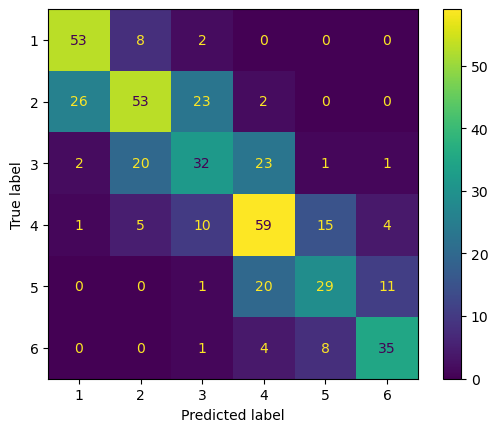

In [53]:
ConfusionMatrixDisplay.from_estimator(pipe_svm, X_test_featurized, y_test)

In [ ]:
import pickle
pickle.dump(pipe_svm, open('cefr_level_SVM.pkl', 'wb'))

## With simplified classes - just A, B, C

In [101]:
with_pos = False

In [102]:
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    data['text'],
    data['encoded_label_simple'],
    test_size=0.2, 
    random_state=42)

In [104]:
pipe_simple = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', SVC(kernel='linear', class_weight="balanced",probability=True))
])
pipe_simple = train_classifier(X_train_simple, y_train_simple, pipe_simple,with_pos=with_pos)

In [ ]:
X_test_featurized_simple = X_test_simple.apply(lambda x: extract_features(x,with_pos=with_pos)).tolist()

In [ ]:
pipe_simple.score(X_test_featurized_simple, y_test_simple)

0.862876254180602

In [ ]:
y_pred_simple = pipe_simple.predict(X_test_featurized_simple)
print(classification_report(y_test_simple, y_pred_simple))

              precision    recall  f1-score   support

           1       0.94      0.93      0.94       119
           2       0.76      0.79      0.78        90
           3       0.86      0.84      0.85        90

    accuracy                           0.86       299
   macro avg       0.86      0.86      0.86       299
weighted avg       0.86      0.86      0.86       299



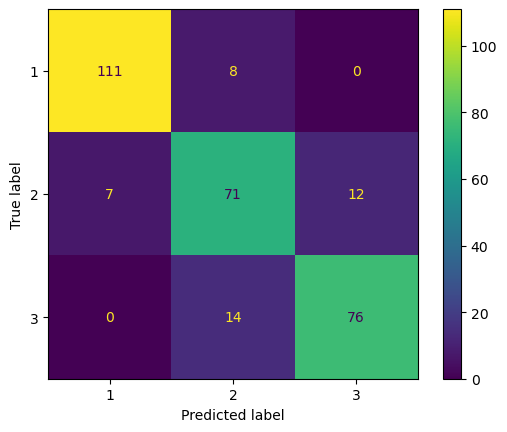

In [91]:
ConfusionMatrixDisplay.from_estimator(pipe_simple, X_test_featurized_simple, y_test_simple)

{'A1-words': 3,
 'A2-words': 0,
 'B1-words': 0,
 'B2-words': 0,
 'C1-words': 1,
 'C2-words': 0}

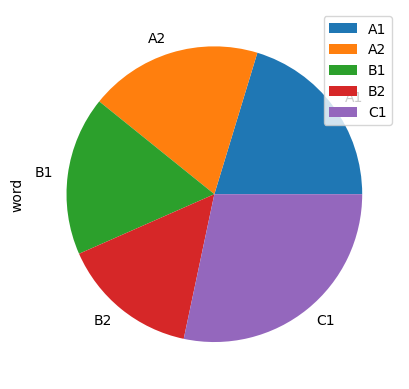

In [184]:
words_by_level = pd.read_csv("datasets/labeled_words.csv")
words_by_level.head()
levels_count = words_by_level.groupby(['level']).count()
levels_count.plot.pie(y="word")
cefr_levels = ["A1","A2","B1","B2","C1","C2"]
def extract_levels_of_words(text):
    levels = {}
    tokenized_words = text.split(" ")
    for l in cefr_levels:
        leveled_words = words_by_level[words_by_level['level'] == l]['word'].values
        l_tag = str(l)+"-words"
        levels[l_tag] = len([word for word in tokenized_words if word in leveled_words])
    return levels

extract_levels_of_words("I am an exceptional student")